# Lab 8: Sampling with Metropolis–Hastings on the Ising Model

### Lab Date: Wednesday, Apr 2

### Lab Due: Wednesday, Apr 16

## Instructions

Work with your lab group to complete the following notebook. Your work will be reviewed by your peers in two weeks (Wednesday, April 16)

In this lab, you will:
1. Implement the Metropolis–Hastings algorithm for the 2D Ising model.
2. Compare different proposal distributions (independent spin flips vs. block updates) and understand their impact on convergence.
3. Test for the end of the burn-in period using visual diagnostics and an automated method.
4. Analyze mixing times.

If you are new to working in python, or in a Jupyter notebook, please ask your lab members for help. If you notice a lab member struggling, and have experience, please offer your help.

Please see this [Ed post](https://edstem.org/us/courses/74615/discussion/6463387) for corrections, questions, and discussion. If you would rather work with your own copy of the files, I have uploaded a zip folder there with the lab materials. 

Corrections to the lab will be pushed directly to this notebook. We will only push corrections to the text, which is set to read only to prevent merge conflicts. In the event of a merge conflict, save your notebook under a different name, and click the link that launches the lab from the schedule on the [stat238 homepage](https://stat238.berkeley.edu/spring-2025/) again. Then, check for discrepancies. If you can't find them, or resolve the conflict, contact us.

## Set Up

In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(123)

## Model

The Ising model is a simplified model of ferromagnetism. It was developed to explain the phase transition between a magnetized and de-magnetized state of metals (e.g. iron) as the temperature of a material increases. It is relevant to us for historical interest (MCMC and Metropolis-Hastings were first developed for problems in statistical mechanics and thermodynamics), is a standard, well-understood pedagogical example, and is an introduction to more advanced models that are areas of active research (spin-glasses, neuron activity, etc). It is a useful pedagogical example since it is easy to specify and simulate, justifies some of the language used in Monte Carlo approaches (e.g. "burn-in", "annealling", "tempering"), and offers a sandbox setting for comparing MCMC methods. 

The 2-D [Ising model](https://en.wikipedia.org/wiki/Ising_model) considers a collection of atoms arranged in a grid. Each atom, $i$, has a magnetic dipole moment or spin $s_i$. The Ising model makes the simplifying assumption that, at any time, each atom has spin "up", $s_i = +1$, or spin "down", $s_i = -1$. A bulk magnetic field arises from a combination of the magnetic moments of all the atoms. If the magnetic moments are arranged uniformly at random then most of the individual magnetic moments cancel out, so the sheet does not act as a magnet. If the magnetic moments align, then the fields combine constructively, so the sheet exhibits magnetism. The average spin across all atoms is typically used to measure magnetization:

$$M(\mathbf{s}) = \frac{1}{N^2} \sum_{i} s_i.$$

To model the development of magnetization, the Ising model assumes that the sheet of atoms are at thermodynamic equilibrium, so the collection of spins is sampled according to a Boltzmann distribution. That is:

$$\text{Pr}(S = s) \propto \exp\left(- \frac{1}{\tau}E(s)\right) $$

where $S$ are the randomly drawn spins for all the atoms, $\tau$ is the temperature (formally, the Boltzmann constant times the temperature), and $E(s)$ is the potential energy stored in the magnetic field when the atoms are arranged with spins $s$. That is, the distribution of spins is exponential in the energy stored in the spin arrangement, with a preference for low energy arrangements. The cooler the material, the stronger this preference. At absolute zero, the metal must adopt a set of spins that minimize the energy $E$. At high temperature, the spins are essentially arranged uniformly. 

Notice that, the Boltzmann distribution can be expressed $\text{Pr}(S = s) \propto \exp(-E(s))^{1/\tau} \propto p(s)^{1/\tau}$ for some fixed distribution $p(s)$ (the Boltzmann with $\tau = 1$). Varying the temperature in this expression from hot to cold is analogous to annealling, a procedure by which a material is heated then cooled. Heating sets $\tau$ large, so raises the distribution $p(s)$ to a power near zero. This makes it very close to uniform. As $\tau$ decreases, the power increases, so the distribution concentrates about its peaks, eventually collapsing into a combination of deltas at the spin arrangements with minimal energy. *Simulated annealling* procedures (e.g. BDA 12.3) take advantage of this idea. They marry a simulation at a desired temperature to simulations at a higher temperature, where the higher temperature distribution acts like a proposal that covers the desired target distribution.

When sufficiently cool, the Ising model will exhibit a phase transition from a de-magnetized to a magnetized state. This transition occurs since $E(s)$ is smaller when the spins of nearby atoms align. The Ising model adopts a particularly simple approximation to the actual field interactions between nearby atoms. It assumes that the energy can be expressed as a sum of the interaction energy between each pair of atoms, $E_{ij}(s)$, that $E_{ij}(s)$ equals zero if the atoms are not neighbors in the grid, and $E_{ij}(s) \propto - s_i s_j$ with a positive proportionality constant shared by all neighboring pairs. The product $- s_i s_j$ is positive if $s_i$ and $s_j$ have opposite signs (misaligned spins) and is negative if they share the same sign (aligned spins). Therefore, to minimize energy, the Ising model will attempt to align spins between neighboring atoms. 

The energy for the full arrangement is then: 

$$E(\mathbf{s}) = -\frac{J}{2} \sum_{\langle i,j \rangle} s_i s_j$$

where the summation runs over all nearest-neighbor pairs, $J > 0$ is the strength of the magnetic interaction between neighboring atoms, and we divide by 2 to avoid double counting.

Our aim is to sample from this model. That is, to sample $S$ from the distribution:

$$\text{Pr}(S = s) \propto \exp \left(\frac{J}{2 \tau} \sum_{\langle i,j \rangle} s_i s_j \right) $$

using Markov Chain Monte Carlo.

**Q 0:** Suppose that we used the Boltzmann distribution as a prior, and measure the magnetization up to some measurement error. Suppose that we observed magnetization $m = M(\mathbf{s}) + \zeta$ where $\mathbf{s}$ is the true set of spins for the material, and where $\zeta \sim \mathcal{N}(0,\sigma^2)$. Write out the posterior distribution for $S$ given $m$ in exponential family form (up to proportionality). How does the observation change the "energy" function ($- \tau \log(\text{Pr}(S = s) )$ as a function of $s$)?

*Note: this is an example of posterior inference using a "first-principles" prior. That is, a prior derived from a model for the process generating the unknown.*

*Write your answer here.*

### Initialize the Ising Grid

The function `initialize_grid(N)` generates an $N \times N$ grid where each site is randomly assigned a spin $+1$ or $-1$. This produces an initial state $\mathbf{s}_0$ by sampling each spin uniformly from $\{+1, -1\}$.

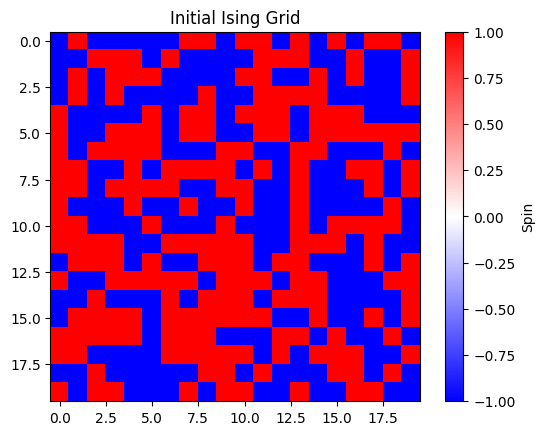

In [2]:
def initialize_grid(N):
    """
    Initialize an N x N grid with spins randomly set to +1 or -1.
    
    Each spin s_i is sampled independently from {+1, -1}.
    """
    return np.random.choice([-1, 1], size=(N, N))

# Example: Initialize a 20x20 grid and display it.
N = 20
grid = initialize_grid(N)
plt.imshow(grid, cmap="bwr")
plt.title("Initial Ising Grid")
plt.colorbar(label="Spin")
plt.show()

### Compute the Energy

The function `compute_energy(grid, J=1)` calculates the energy using periodic boundary conditions. The energy is given by:

$$E(\mathbf{s}) = -\frac{J}{2} \sum_{\langle i,j \rangle} s_i s_j,$$

where the summation is over all nearest-neighbor pairs and we divide by 2 to avoid double counting. Periodic boundaries ensure neighbors “wrap around.”

In [3]:
def compute_energy(grid, J=1):
    """
    Compute the energy of the grid using the Ising Hamiltonian with periodic boundaries.
    
    Mathematical Formulation:
      H(s) = -J * sum_{<i,j>} s_i * s_j,
    with each nearest-neighbor pair counted twice.
    """
    N = grid.shape[0]
    energy = 0
    for i in range(N):
        for j in range(N):
            s = grid[i, j]
            # Nearest neighbors with periodic boundary conditions.
            neighbors = (grid[(i+1) % N, j] +
                         grid[(i-1) % N, j] +
                         grid[i, (j+1) % N] +
                         grid[i, (j-1) % N])
            energy += -J * s * neighbors
    return energy / 2  # Correct for double counting

# Example: Compute and display the energy of the initial grid.
energy0 = compute_energy(grid)
print("Initial Energy:", energy0)

Initial Energy: 0.0


## Markov Chain Monte Carlo

We will use the [Metropolis-Hastings (MH) algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) and [Gibbs Sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) to generate samples from the Ising model. 

#### Metropolis-Hastings:

The MH algorithm is an example of a Markov Chain Monte Carlo (MCMC) method. It specifies a Markov chain whose steady state distribution equals a desired target distribution. 

MH proceeds in two stages per step. Given an initial state, it proposes a perturbation to that state using a tractable proposal (or jump) distribution. Then, it decides whether to accept or reject the candidate state. The probability of acceptance is determined by comparing the probabilities of the original state and the candidate state. 

Let $p_r(s \rightarrow s')$ denote the probability that the proposal (or jump) distribution proposed a candidate state $s'$ given an initial state $s$. Let $\tilde{p}_*(s)$ denote the unnormalized target distribution. Then, the acceptance probability for the jump is set to:

$$\text{min}\left\{\frac{\tilde{p}_*(s')}{\tilde{p}_*(s)} \frac{p_r(s' \rightarrow s)}{p_r(s \rightarrow s')},1\right\} $$

Review chapter 11.2 in BDA for a full specification. For an example, see the [Lab 6 demo](https://datahub.berkeley.edu/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fberkeley-stat238%2Fspring-2025&urlpath=tree%2Fspring-2025%2Flabs%2Flab06%2FLab_6_tutorial.ipynb&branch=main).

Note that, if we use a symmetric proposal, then $p_r(s' \rightarrow s) = p_r(s \rightarrow s')$, so MH reduces to the Metropolis algorithm. Further, if we set $\tilde{p}_*(s)$ to the Boltzmann distribution, then the target odds can be expressed:

$$
\frac{\tilde{p}_*(s')}{\tilde{p}_*(s)} = \exp(-\tfrac{1}{\tau}(E(s') - E(s))) = \exp(-\tfrac{1}{\tau} \Delta E(s,s'))
$$

#### Gibbs Sampling:

Gibbs sampling is an MCMC algorithm that iteratively resamples a subset of the unknowns (here, a subset of the spins), conditional on the rest (here, conditional on the remaining spins). For details, see BDA Chapter 11.1. Gibbs sampling is a special instance of the MH algorithm, although, for implementation it is often easier to construct separately. Gibbs sampling works well for target distributions with tractable conditionals, and, with approximately independent subsets of variables. This is a common feature in heirarchical models built from conditionally conjugate distributions. It is also a feature of the Ising model.

### Proposals:

#### Proposal I: Independent Spin Flips

**Q 1:** In the space below, complete the function `proposal_independent(grid, flip_prob)` that updates each spin independently by flipping it with probability $p =$ `flip_prob`. This update represents a local change, where each spin’s new value is given by:
$$s_i \rightarrow -s_i \quad \text{with probability } p.$$
Because the proposal is symmetric, the MH acceptance probability depends only on the energy difference.

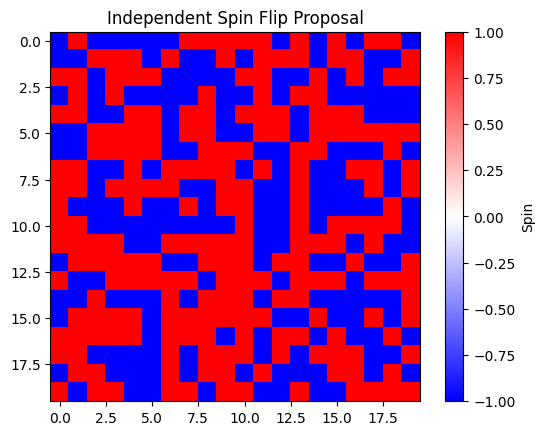

In [4]:
def proposal_independent(grid, flip_prob):
    """
    For each spin in the grid, flip its sign with probability flip_prob.
    
    This implements a local update with a symmetric proposal.
    """
    new_grid = grid.copy() # set the new grid of spins equal to the old grid of spins
    N = grid.shape[0] # extract the side-length
    ... # insert your proposal code here
    return new_grid

# Example: Apply the independent spin flip proposal with a 5% flip probability.
flip_prob = 0.05
grid_proposed = proposal_independent(grid, flip_prob)
plt.imshow(grid_proposed, cmap="bwr")
plt.title("Independent Spin Flip Proposal")
plt.colorbar(label="Spin")
plt.show()

#### Proposal II: Block Updates

In general, the efficiency of a MH scheme depends on the choice of proposal (or jump) distribution. Ideally, the proposal should be chosen by studying the target distribution. Since the Ising model tends to produce clusters of atoms with matching spins, it may help to use an update that acts locally and preserves magnetization within sub-blocks of the overall grid. 

As a comparison, we've implemented a function `proposal_block_update(grid, block_size, update_fraction)` that partition the grid into $k \times k$ blocks and randomly scramble the spins in a fraction $p =$ `update_fraction` of these blocks. More formally, it divides the grid into blocks. Then, given $M$ blocks, approximately $p \times M$ blocks are chosen to update. Within each chosen block, the spins are randomly permuted (uniformly over all possible arrangements), ensuring a symmetric proposal.

Think carefully about the advantages and disadvantages of this proposal relative to the first proposal. 

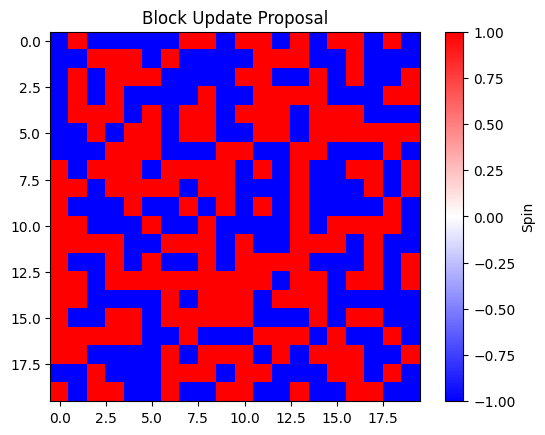

In [5]:
def proposal_block_update(grid, block_size, update_fraction):
    """
    Partition the grid into blocks of size block_size x block_size.
    Randomly select a fraction update_fraction of blocks and scramble their spins.
    
    Assumption: Grid size N is divisible by block_size.
    """
    N = grid.shape[0]
    new_grid = grid.copy()
    num_blocks = N // block_size  # number of blocks per dimension
    total_blocks = num_blocks * num_blocks
    num_to_update = int(np.ceil(update_fraction * total_blocks))
    
    # List of block indices.
    blocks = [(i, j) for i in range(num_blocks) for j in range(num_blocks)]
    selected_indices = np.random.choice(len(blocks), size=num_to_update, replace=False)
    
    for idx in selected_indices:
        block_i, block_j = blocks[idx]
        start_i = block_i * block_size
        start_j = block_j * block_size
        block = new_grid[start_i:start_i + block_size, start_j:start_j + block_size]
        block_flat = block.flatten()
        np.random.shuffle(block_flat)
        new_grid[start_i:start_i + block_size, start_j:start_j + block_size] = block_flat.reshape(block_size, block_size)
    
    return new_grid

# Example: Apply block update with block size 4 and 30% of blocks updated.
block_size = 4
update_fraction = 0.3
grid_proposed_block = proposal_block_update(grid, block_size, update_fraction)
plt.imshow(grid_proposed_block, cmap="bwr")
plt.title("Block Update Proposal")
plt.colorbar(label="Spin")
plt.show()

### Updates:

#### Metropolis Update Step:

**Q 2:** In the space below, complete the function `metropolis_step(grid, proposal_func, temperature, **proposal_kwargs)` that carries out one MH update. It should calculate the energy $E(\mathbf{s})$ of the current state, propose a new state $\mathbf{s}^{\prime}$, compute $\Delta E(\mathbf{s},\mathbf{s}') = E(\mathbf{s}^{\prime}) - E(\mathbf{s})$, and accept $\mathbf{s}^{\prime}$ with probability

$$\alpha(\mathbf{s}, \mathbf{s}^{\prime}) = \min\left\{\exp\left(-\tfrac{1}{\tau} \Delta E (\mathbf{s},\mathbf{s}') \right),1\right\}.$$

This acceptance probability ensures detailed balance and drives the chain towards the equilibrium distribution.

In [57]:
def metropolis_step(grid, proposal_func, temperature, **proposal_kwargs):
    """
    Perform one Metropolis–Hastings update step.
    
    Steps:
      1. Compute current energy H(s).
      2. Generate proposed state s' using proposal_func.
      3. Compute ΔH = H(s') - H(s).
      4. Accept s' with probability: min(1, exp(-ΔH/T)).
    
    Returns:
      new_grid: the updated configuration.
      accepted: True if the move is accepted; otherwise, False.
    """
    current_energy = compute_energy(grid)
    
    proposed_grid = proposal_func(grid, **proposal_kwargs)
    
    proposed_energy = compute_energy(proposed_grid)
    
    delta_E = ... # compute the change in energy
    
    if ... # implement the MH acceptance rule here
        return proposed_grid, True
    else:
        return grid, False

# Test one MH step using the independent proposal.
temperature = 2/(np.log(1+np.sqrt(2)))
grid, accepted = metropolis_hastings_step(grid, proposal_independent, temperature, flip_prob=flip_prob)
print("MH Step accepted?", accepted)

NameError: name 'np' is not defined

#### Gibbs Update Step:

**Q 3:** For each atom $i$, find a set of atoms $\mathcal{N}(i)$ such that $S_i$ is conditionally independent of $S_k$ for any $k \notin \mathcal{N}(i)$, given the value of the spins of all atoms $j \in \mathcal{N}(i)$.

*Write your answer here.*

**Q 4:** Using your answer to question 3, find the exact conditional distribution for $S_i$ as a function of the spins in its neighborhood, $\mathcal{N}(i)$, and the parameters $\tau, J$.

*Write your answer here.*

**Q 5:** Using your answer to question 3, show that, if the total number of grid cells long each side of the grid even, then the grid can be partitioned into two sets of atoms where all the spins in the first set are conditionally independent of one another given all the spins in the second set and visa-versa. (*Hint: it may help to draw the grid and neighborhoods*). Use your result to argue that, given even side-lengths, we can implement a Gibbs sampling procedure that uses two blocks of spins, and, that when resampling each block, we can draw all the spins within a block independently from each other.

*Write your answer here.*

**Q 6:** Based on questions 3 - 5, write a psuedocode outlining a Gibbs sampling procedure for sampling from the Ising model:

*Write your answer here.*

**Q 7:** In the space below implement a function that performs a single pair of Gibbs sampling steps (completes one resample of every spin). Your code should imitate the format of the `metropolis_step` function implemented above.

In [ ]:
# write your function here

## Simulation

The function `run_MH_simulation(initial_grid, proposal_func, temperature, n_steps, **proposal_kwargs)` runs the MH algorithm for a fixed number of iterations. It also records both the energy and the magnetization at each step. Tracking $E(\mathbf{s})$ and $M(\mathbf{s})$ will help to monitor convergence.

**Q 8:** Modify the function below to track the acceptance rate (fraction of accepted steps), and to stop on the total number of accepted steps instead of the total number of proposed steps.

In [ ]:
def run_MH_simulation(initial_grid, proposal_func, temperature, n_steps, **proposal_kwargs):
    """
    Run the MH simulation for n_steps iterations.
    
    Records:
      - Energy: H(s)
      - Magnetization: M = (1/N^2) * sum(s)
    
    Returns:
      grid: Final configuration.
      energies: Array of energy values over iterations.
      magnetizations: Array of magnetization values over iterations.
    """
    grid = initial_grid.copy()
    energies = []
    magnetizations = []
    acceptance_rate = 0 # Initialize acceptance rate
    
    for step in range(n_steps):
        grid, ... = metropolis_step(grid, proposal_func, temperature, **proposal_kwargs)
        energies.append(compute_energy(grid))
        magnetizations.append(np.mean(grid))
        acceptance_rate = ... # modify to track the acceptance rate 
    
    return grid, np.array(energies), np.array(magnetizations)

**Q 10:** Experiment with both MH algorithms below. Vary the parameters for the proposal distributions until you are satisfied with the acceptance rates.

In [ ]:
# Example: Run simulation with the independent spin flip proposal.
n_steps = 10000
# Independent Spin Flips Simulation
grid0_indep = initialize_grid(N)
grid_final_indep, energies_indep, magnetizations_indep = run_MH_simulation(
    grid0_indep, proposal_independent, temperature, n_steps, flip_prob=flip_prob
)

In [ ]:
# Example: Run simulation with the block updates proposal
grid0_block = initialize_grid(N)
grid_final_block, energies_block, magnetizations_block = run_MH_simulation(
    grid0_block, proposal_block_update, temperature, n_steps, block_size=block_size, update_fraction=update_fraction
)

**Q 11:** In the space below write a `run_Gibbs_simulation` function that implements your Gibbs sampling procedure. As before, imitate the structure of the `run_MH_simulation` as closely as possible (in particular, match the format for the outputs and relevant inputs). Then, generate a simulation run as an example.

In [ ]:
# write your function here

### Visual Diagnostics and Burn-In Detection

MCMC methods depend on an asymptotic guarantee. Given *long enough* the sample trajectories will produce states sampled from the target distribution. The samples produced by the initial stages of MCMC are usually drawn from an ensemble that is far from the stationary ensemble produced by initializing from the target. This early phase is usually called the "burn-in" phase, and is typically discarded from the sample run.

**Q 12:** Plot the energy and magnetization along each simulation versus iteration to visually assess convergence.

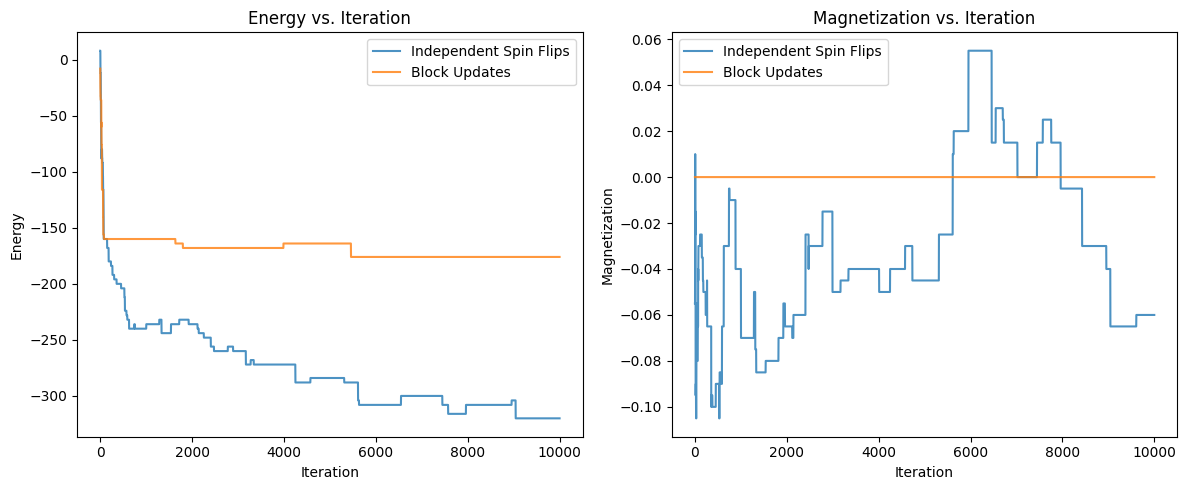

In [8]:
plt.figure(figsize=(12,5))

# Plot energy for both proposals.
plt.subplot(1,2,1)
plt.plot(energies_indep, label="Independent Spin Flips", alpha=0.8)
plt.plot(energies_block, label="Block Updates", alpha=0.8)
... # add the output of your Gibbs simulation here
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Energy vs. Iteration")
plt.legend()

# Plot magnetization for both proposals.
plt.subplot(1,2,2)
plt.plot(magnetizations_indep, label="Independent Spin Flips", alpha=0.8)
plt.plot(magnetizations_block, label="Block Updates", alpha=0.8)
... # add the output of your Gibbs simulation here
plt.xlabel("Iteration")
plt.ylabel("Magnetization")
plt.title("Magnetization vs. Iteration")
plt.legend()

plt.tight_layout()
plt.show()

**Q 13:** Inspect the plots above and compare the convergence behavior of the three simulation methods. Which converges fastest? Why? Do all of the methods appear consistent with each other? If not, try to explain why. Pay close attention to the characteristics of the proposals used.

*Write your answer here.*

**Q 14:** Based on your observations, suggest an alternate proposal distribution for MH. Explain why (a) it is valid, and (b) why you think it might lead to better performance.

*Write your answer here.*

**Q 15:** Discuss how your answer would change if we had observed (a) the exact magnetization, or (b) a subset of spins exactly, and aimed to sample from the posterior over possible spin arrangements.

*Write your answer here.*

**Q 15:** In the space below, write a function to automatically detect the end of the burn-in period using the sequence of observed energies and magnetizations. Check BDA 11.4 for advice on assessing convergence. Explain the rationale for your procedure in the comment section of the code below.

Independent Spin Flips: Estimated burn-in (energy) ends at iteration: 9032
Block Updates: Estimated burn-in (energy) ends at iteration: 5450


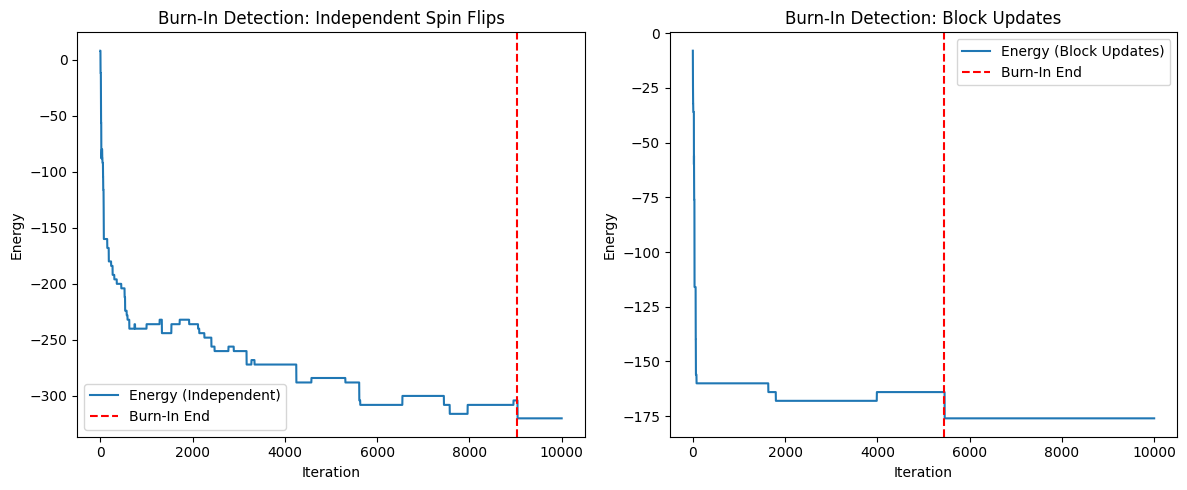

In [9]:
def detect_burn_in_energy(...):
    """
    Estimate the burn-in period using energy and magnetization as the observable by ...
    
    Parameters:
      energy_series : 1D numpy array of energy values.
      magnetization_series : 1D numpy array of magnetization values.
      ...
    
    Returns:
      The estimated burn-in iteration.
    """
    
    return ...

# Detect end of burn-in period for all three simulations
burn_in_energy_indep = detect_burn_in_energy(...)
burn_in_energy_block = detect_burn_in_energy(...)
burn_in_energy_block = ... # repeat for Gibbs here


print("Independent Spin Flips: Estimated burn-in (energy) ends at iteration:", burn_in_energy_indep)
print("Block Updates: Estimated burn-in (energy) ends at iteration:", burn_in_energy_block)

# Plot energy with burn-in detection for Independent Spin Flips.
plt.figure(figsize=(12,5))
plt.subplot(1,2,3)
plt.plot(energies_indep, label="Energy (Independent)")
plt.axvline(burn_in_energy_indep, color='red', linestyle='--', label="Burn-In End")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Burn-In Detection: Independent Spin Flips")
plt.legend()

# Plot energy with burn-in detection for Block Updates.
plt.subplot(1,2,3)
plt.plot(energies_block, label="Energy (Block Updates)")
plt.axvline(burn_in_energy_block, color='red', linestyle='--', label="Burn-In End")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Burn-In Detection: Block Updates")
plt.legend()

# Plot energy with burn-in detection for Gibbs.
plt.subplot(1,3,3)
... # repeat for Gibbs
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Burn-In Detection: Block Updates")
plt.legend()

plt.tight_layout()
plt.show()

## Mixing Times

The efficiency of an MCMC scheme depends primarily on its mixing times. These control the length of the burn-in period, and the autocorrelation of the generated samples. Note, these two times need not be the same. 

**Q 16:** In the space below, write a code that, after discarding the burn-in period, estimates the effective number of samples generated based on the autocorrelation in the time series for the energy and the magnetization (see BDA 11.5). Use the smaller of the two numbers as a measure of the effective sample size. 

In [ ]:
# Write your code here

**Q 17:** Based on this measure, which of the *valid* methods mixes the fastest (has the largest effective sample size)?

*Write your answer here.*

**Q 18:** *Optional* Select this method, and use it to complete problem 11.6 (b) in BDA.

In [ ]:
# Write your code here.

**Q 19:** *Optional* The Ising model is often introduced since it provides a useful toy environment for exploration and experimentation. I've outlined an experiment below that could be adapted as part of a mini-project.

Select the fastest method, and use it to explore the mixing time (total number of samples divided by effective number of samples), as a function of gridsize and temperature. I'd suggest using a logarithmic spacing for both, a coarse grid size sampling (say sizes 4, 16, 64, 256), and a fine temperature spacing. 

In particular, if you plot the average absolute magnetization (after burn-in) as a function of temperature for each grid size, you should see a transition between a demagnetized and a magnetized state as the material cools. This transition should sharpen, as a function of temperature, as the grid size increases. The critical temperature for the material is, roughly speaking, the temperature at which this transition occurs. We can estimate it hueristically by either selecting the temperature at which the average absolute magnetization crosses 1/2 its peak value (value at absolute zero), or, where it changes the quickest as a function of temperature. 

Estimate the critical temperature for each grid size, then make a plot showing the mixing time as a function of grid-size at three different temperatures: near absolute zero, at the critical temperature per grid size, and at a very high temperature. Pick your axis scales appropriately (e.g. linear vs log). How does the mixing time depend on the temperature? Is it slowest at criticality?